# Fetal Health Classification Project

2022 ml-zoomcamp midterm project, Lisa Novello

Data were retrieved [here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) from Kaggle, and are based on:

Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318

The goal of this project is to classify fetal health based on records extracted from Cardiotocograms (CTGs), i.e. instruments measuring _e.g._ fetal heart rate, fetal movements, _etc._, via ultrasound pulses. 
Fetal health has been classified by expert obstetritians into 3 classes:
- Normal
- Suspect
- Pathological.

The goal of this project is to build a multiclass classification model allowing to categorize each fetus' health into one of the above three classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from dtreeviz.trees import dtreeviz

import xgboost as xgb
import bentoml

Data import:

In [2]:
data = '/home/lisa/Documents/ml-projects/fetal-health-classification/dataset/fetal_health.csv'
df = pd.read_csv(data)
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [3]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125
baseline value,120.0,132.000,133.000,134.000,132.000,134.000,134.000,122.0,122.000,122.000,...,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,142.000
accelerations,0.0,0.006,0.003,0.003,0.007,0.001,0.001,0.0,0.000,0.000,...,0.004,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.002
fetal_movement,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002
uterine_contractions,0.0,0.006,0.008,0.008,0.008,0.010,0.013,0.0,0.002,0.003,...,0.004,0.008,0.006,0.007,0.005,0.007,0.007,0.007,0.006,0.008
light_decelerations,0.0,0.003,0.003,0.003,0.000,0.009,0.008,0.0,0.000,0.000,...,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000
severe_decelerations,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
prolongued_decelerations,0.0,0.000,0.000,0.000,0.000,0.002,0.003,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
abnormal_short_term_variability,73.0,17.000,16.000,16.000,16.000,26.000,29.000,83.0,84.000,86.000,...,80.000,79.000,79.000,79.000,77.000,79.000,78.000,79.000,78.000,74.000
mean_value_of_short_term_variability,0.5,2.100,2.100,2.400,2.400,5.900,6.300,0.5,0.500,0.300,...,0.200,0.300,0.500,0.600,0.700,0.200,0.400,0.400,0.400,0.400
percentage_of_time_with_abnormal_long_term_variability,43.0,0.000,0.000,0.000,0.000,0.000,0.000,6.0,5.000,6.000,...,36.000,20.000,26.000,27.000,17.000,25.000,22.000,20.000,27.000,36.000


## Preprocessing

In [4]:
df.columns = df.columns.str.replace(' ', '_')
df.T

,0,1,2,3,4,5,6,7,8,9,...,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125
baseline_value,120.0,132.000,133.000,134.000,132.000,134.000,134.000,122.0,122.000,122.000,...,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,142.000
accelerations,0.0,0.006,0.003,0.003,0.007,0.001,0.001,0.0,0.000,0.000,...,0.004,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.002
fetal_movement,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002
uterine_contractions,0.0,0.006,0.008,0.008,0.008,0.010,0.013,0.0,0.002,0.003,...,0.004,0.008,0.006,0.007,0.005,0.007,0.007,0.007,0.006,0.008
light_decelerations,0.0,0.003,0.003,0.003,0.000,0.009,0.008,0.0,0.000,0.000,...,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000
severe_decelerations,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
prolongued_decelerations,0.0,0.000,0.000,0.000,0.000,0.002,0.003,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
abnormal_short_term_variability,73.0,17.000,16.000,16.000,16.000,26.000,29.000,83.0,84.000,86.000,...,80.000,79.000,79.000,79.000,77.000,79.000,78.000,79.000,78.000,74.000
mean_value_of_short_term_variability,0.5,2.100,2.100,2.400,2.400,5.900,6.300,0.5,0.500,0.300,...,0.200,0.300,0.500,0.600,0.700,0.200,0.400,0.400,0.400,0.400
percentage_of_time_with_abnormal_long_term_variability,43.0,0.000,0.000,0.000,0.000,0.000,0.000,6.0,5.000,6.000,...,36.000,20.000,26.000,27.000,17.000,25.000,22.000,20.000,27.000,36.000


Let's replace "percentage_of_time" with "pot".

In [5]:
df.columns = df.columns.str.replace('percentage_of_time', 'pot')
df.T

,0,1,2,3,4,5,6,7,8,9,...,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125
baseline_value,120.0,132.000,133.000,134.000,132.000,134.000,134.000,122.0,122.000,122.000,...,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,140.000,142.000
accelerations,0.0,0.006,0.003,0.003,0.007,0.001,0.001,0.0,0.000,0.000,...,0.004,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.002
fetal_movement,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002
uterine_contractions,0.0,0.006,0.008,0.008,0.008,0.010,0.013,0.0,0.002,0.003,...,0.004,0.008,0.006,0.007,0.005,0.007,0.007,0.007,0.006,0.008
light_decelerations,0.0,0.003,0.003,0.003,0.000,0.009,0.008,0.0,0.000,0.000,...,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000
severe_decelerations,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
prolongued_decelerations,0.0,0.000,0.000,0.000,0.000,0.002,0.003,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
abnormal_short_term_variability,73.0,17.000,16.000,16.000,16.000,26.000,29.000,83.0,84.000,86.000,...,80.000,79.000,79.000,79.000,77.000,79.000,78.000,79.000,78.000,74.000
mean_value_of_short_term_variability,0.5,2.100,2.100,2.400,2.400,5.900,6.300,0.5,0.500,0.300,...,0.200,0.300,0.500,0.600,0.700,0.200,0.400,0.400,0.400,0.400
pot_with_abnormal_long_term_variability,43.0,0.000,0.000,0.000,0.000,0.000,0.000,6.0,5.000,6.000,...,36.000,20.000,26.000,27.000,17.000,25.000,22.000,20.000,27.000,36.000


In [6]:
df.isnull().sum()

baseline_value                             0
accelerations                              0
fetal_movement                             0
uterine_contractions                       0
light_decelerations                        0
severe_decelerations                       0
prolongued_decelerations                   0
abnormal_short_term_variability            0
mean_value_of_short_term_variability       0
pot_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability        0
histogram_width                            0
histogram_min                              0
histogram_max                              0
histogram_number_of_peaks                  0
histogram_number_of_zeroes                 0
histogram_mode                             0
histogram_mean                             0
histogram_median                           0
histogram_variance                         0
histogram_tendency                         0
fetal_health                               0
dtype: int

There is no missing values.

Let's visualize the data.

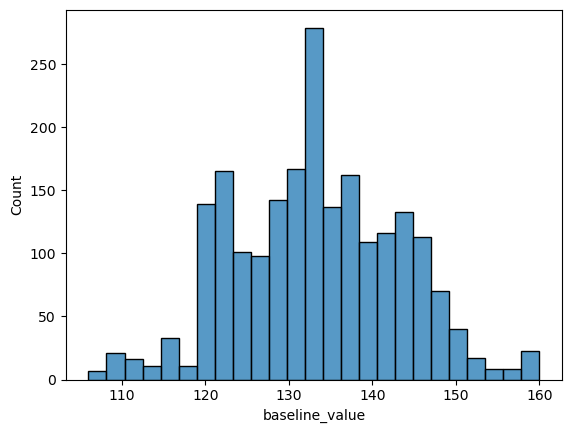

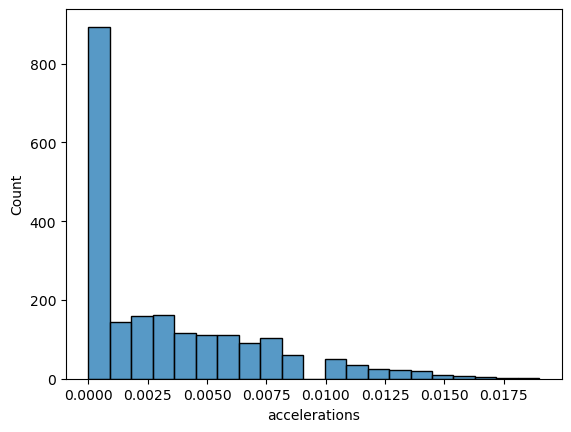

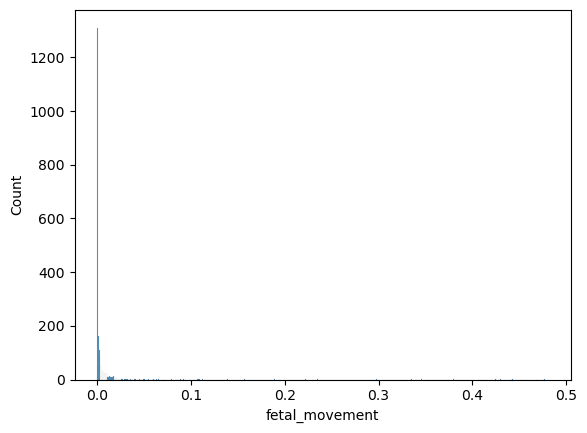

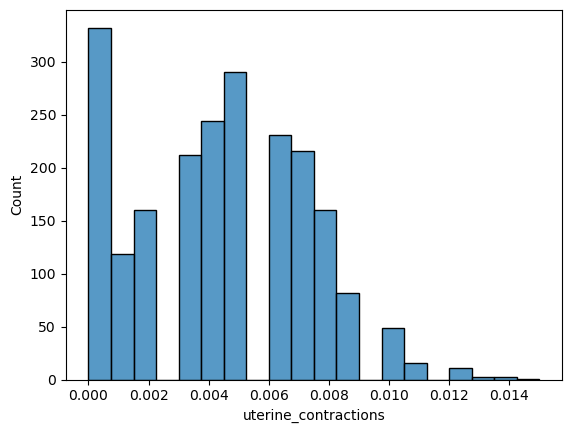

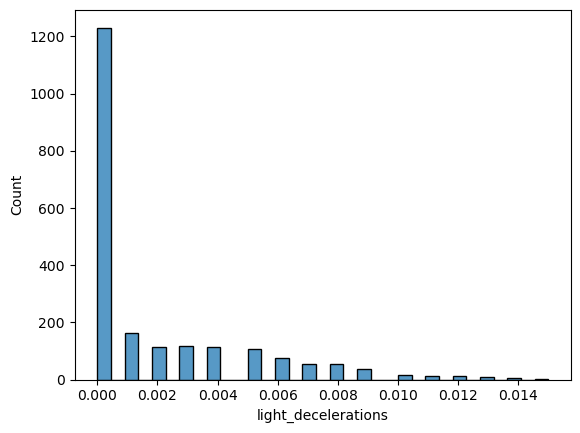

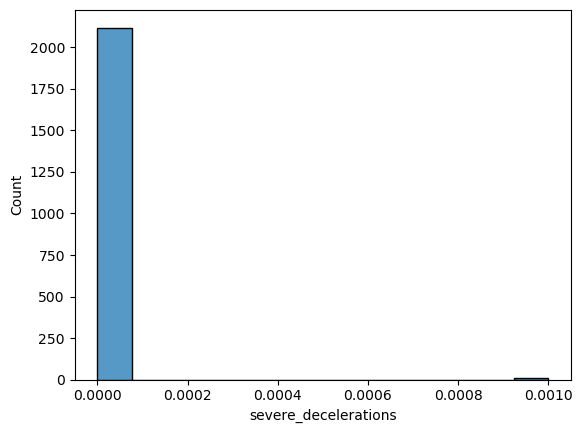

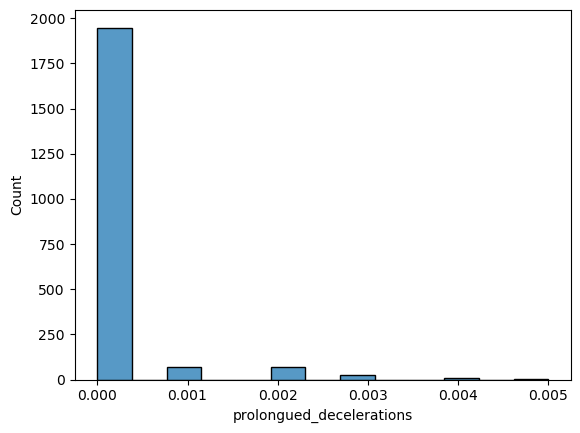

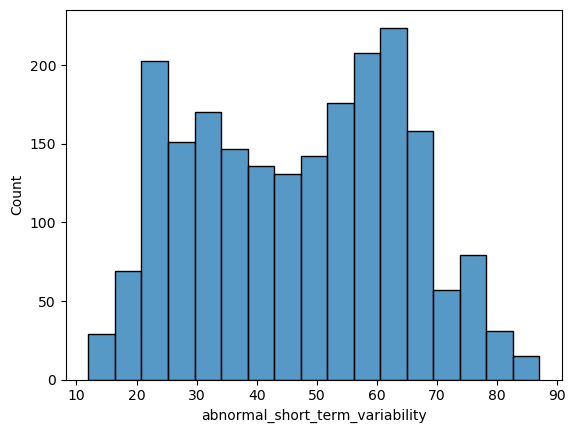

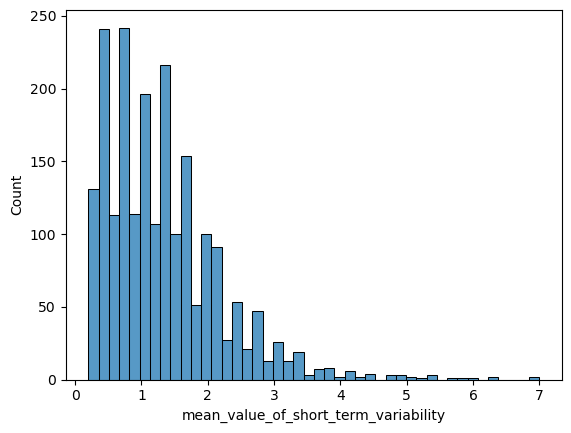

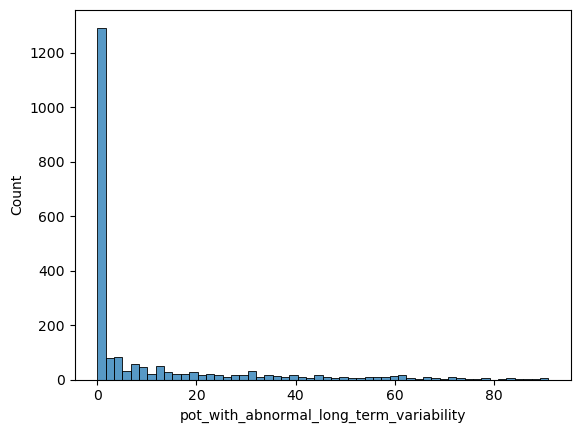

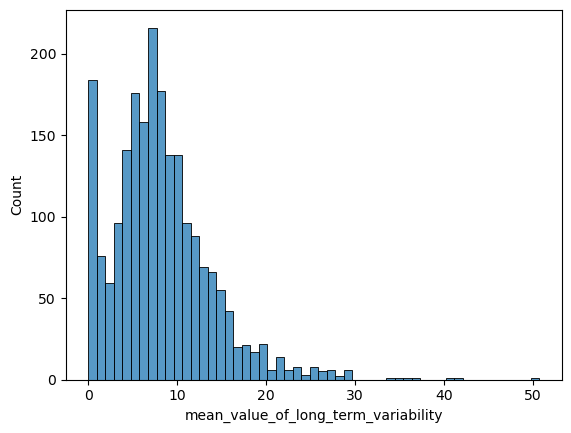

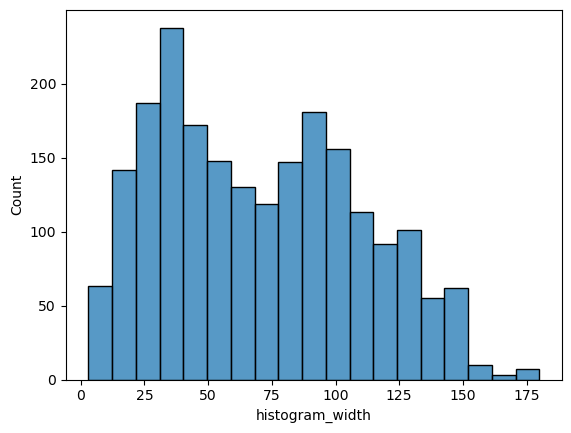

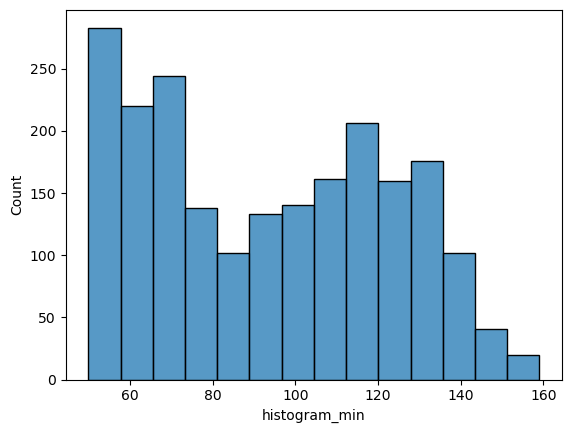

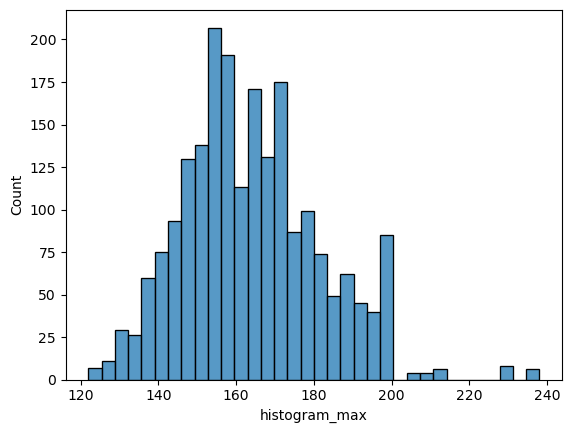

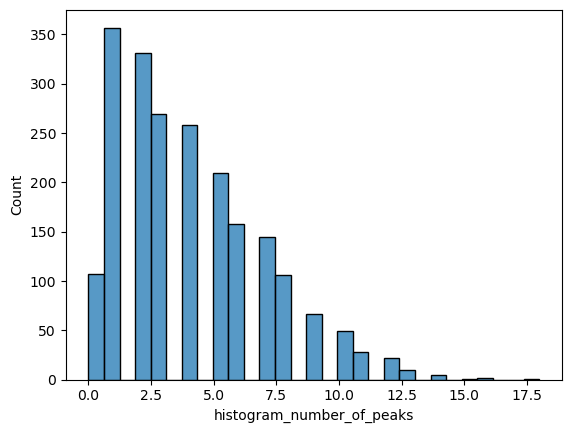

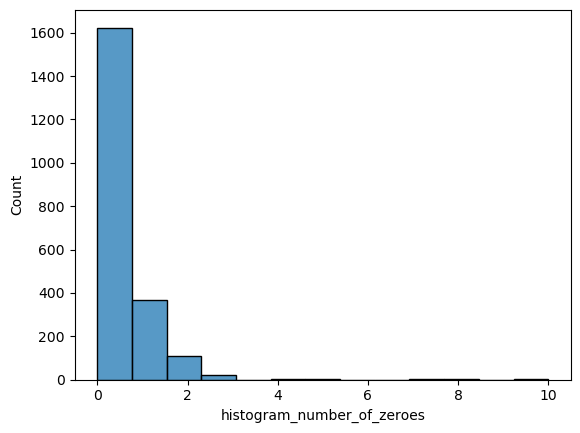

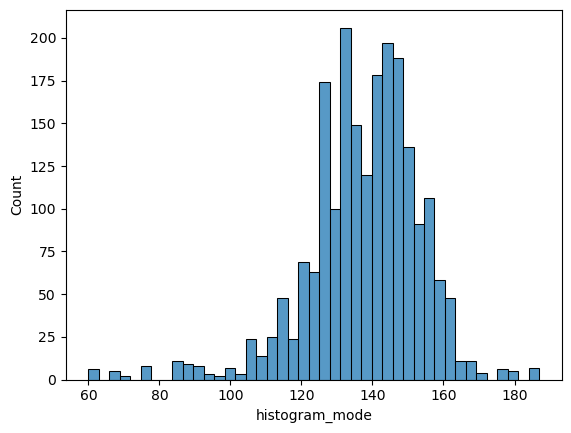

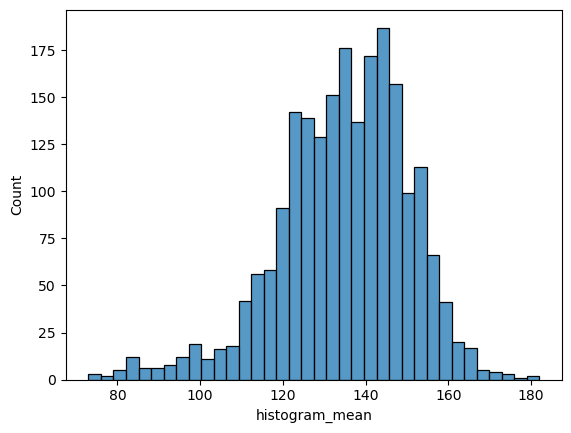

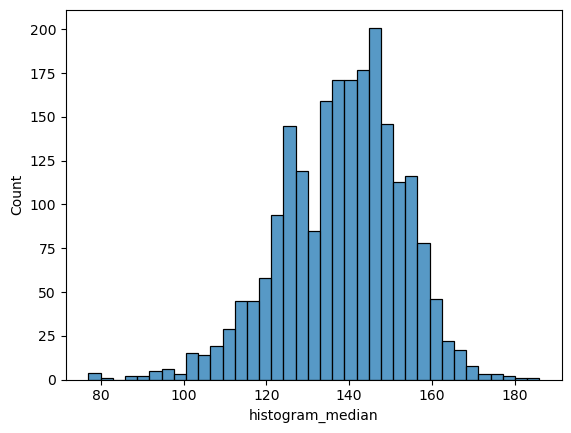

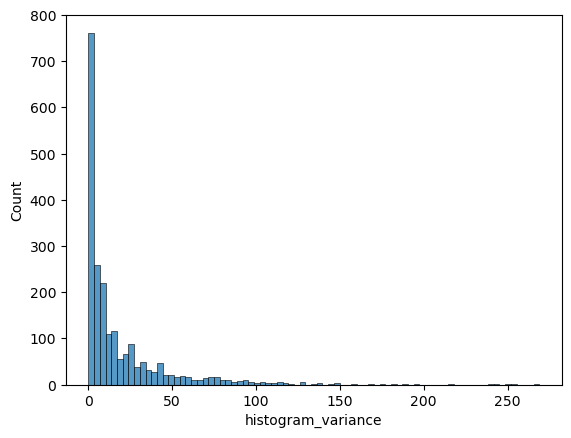

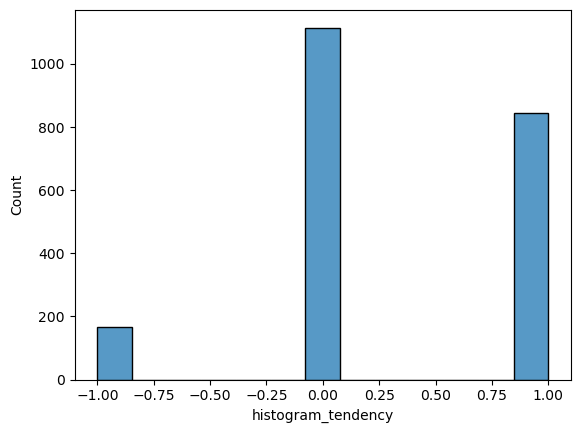

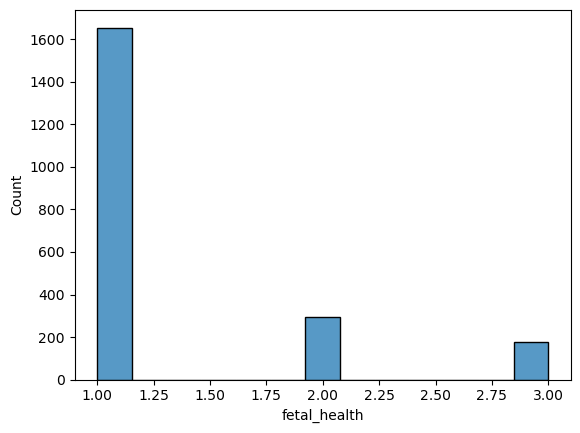

In [7]:
for c in df.columns:
    
    sns.histplot(df[c])
    plt.show()

There are some skewed features. These are:
- `accelerations`
- `fetal_movement`
- `light_decelerations`
- `severe_decelerations`
- `prolongued_decelerations`
- `mean_value_of_short_term_variability`
- `pot_with_abnormal_long_term_variability`
- `mean_value_of_long_term_variability`
- `histogram_number_of_peaks`
- `histogram_number_of_zeroes`
- `histogram_variance`

In [8]:
categories_log = ['mean_value_of_short_term_variability',
                  'mean_value_of_long_term_variability',
                  'histogram_number_of_peaks',
                  'histogram_variance']

In [9]:
categories_sqrt = ['accelerations',
                   'fetal_movement',
                   'light_decelerations',
                   'severe_decelerations',
                   'prolongued_decelerations',
                   'pot_with_abnormal_long_term_variability',
                   'histogram_number_of_zeroes']

Let's apply a log-transformation for `categories_log` and a square-root transformation for `categories_sqrt`:

In [10]:
for c in categories_log:
    
    df[c] = np.log1p(df[c])

In [11]:
for s in categories_sqrt:
    
    df[s] = np.sqrt(df[s])

In [12]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125
baseline_value,120.000000,132.000000,133.000000,134.000000,132.000000,134.000000,134.000000,122.000000,122.000000,122.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,142.000000
accelerations,0.000000,0.077460,0.054772,0.054772,0.083666,0.031623,0.031623,0.000000,0.000000,0.000000,...,0.063246,0.000000,0.000000,0.000000,0.000000,0.000000,0.031623,0.031623,0.031623,0.044721
fetal_movement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044721
uterine_contractions,0.000000,0.006000,0.008000,0.008000,0.008000,0.010000,0.013000,0.000000,0.002000,0.003000,...,0.004000,0.008000,0.006000,0.007000,0.005000,0.007000,0.007000,0.007000,0.006000,0.008000
light_decelerations,0.000000,0.054772,0.054772,0.054772,0.000000,0.094868,0.089443,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031623,0.031623,0.031623,0.000000,0.000000,0.000000,0.000000,0.000000
severe_decelerations,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
prolongued_decelerations,0.000000,0.000000,0.000000,0.000000,0.000000,0.044721,0.054772,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
abnormal_short_term_variability,73.000000,17.000000,16.000000,16.000000,16.000000,26.000000,29.000000,83.000000,84.000000,86.000000,...,80.000000,79.000000,79.000000,79.000000,77.000000,79.000000,78.000000,79.000000,78.000000,74.000000
mean_value_of_short_term_variability,0.405465,1.131402,1.131402,1.223775,1.223775,1.931521,1.987874,0.405465,0.405465,0.262364,...,0.182322,0.262364,0.405465,0.470004,0.530628,0.182322,0.336472,0.336472,0.336472,0.336472
pot_with_abnormal_long_term_variability,6.557439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.449490,2.236068,2.449490,...,6.000000,4.472136,5.099020,5.196152,4.123106,5.000000,4.690416,4.472136,5.196152,6.000000


Let's visualize the transformed data:

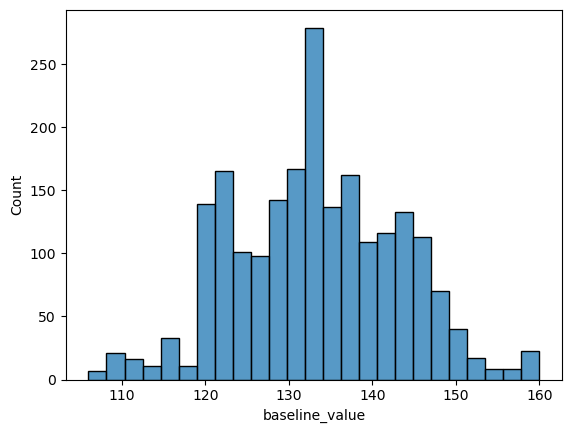

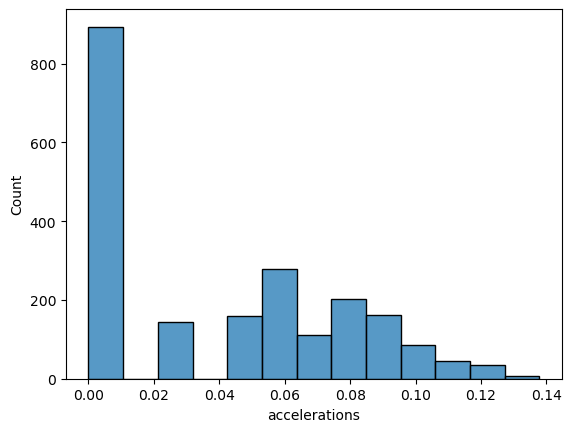

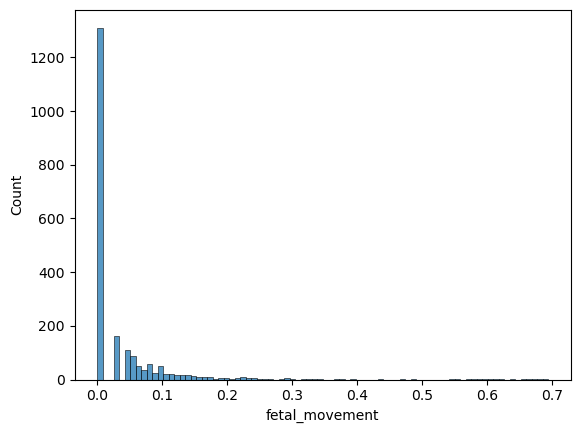

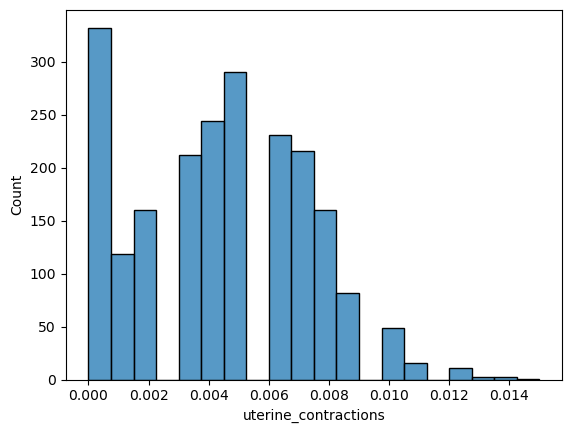

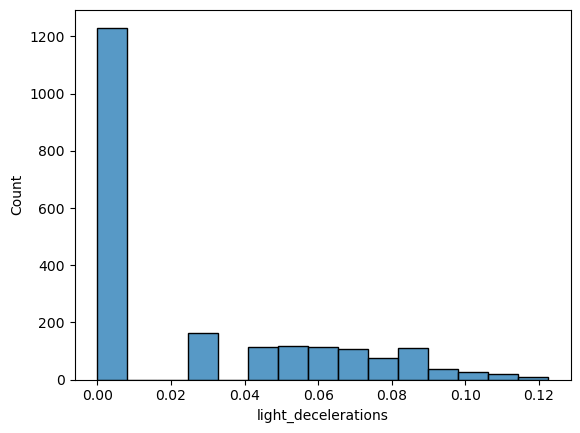

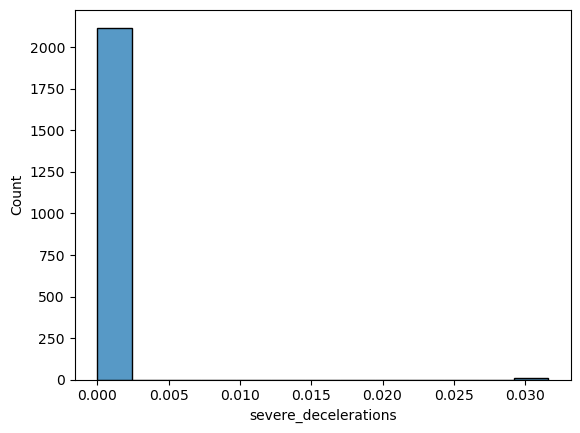

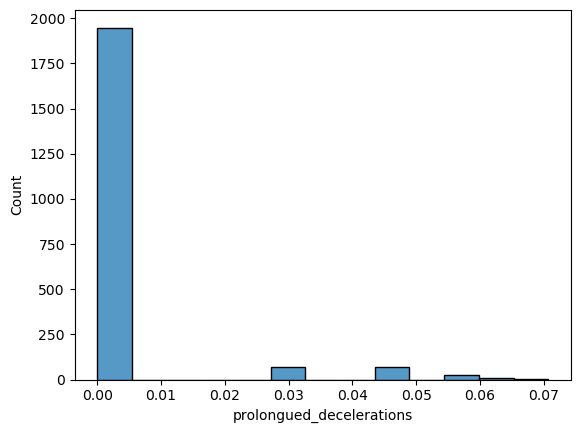

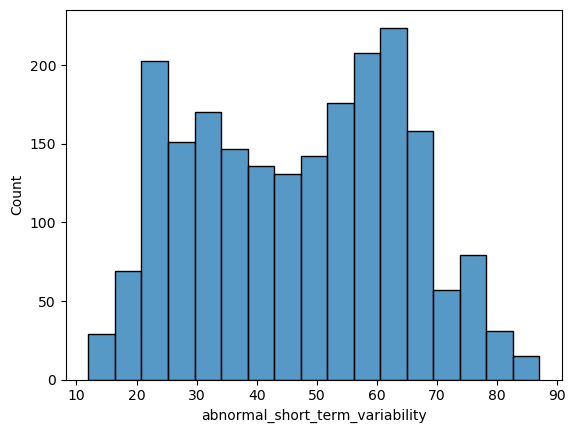

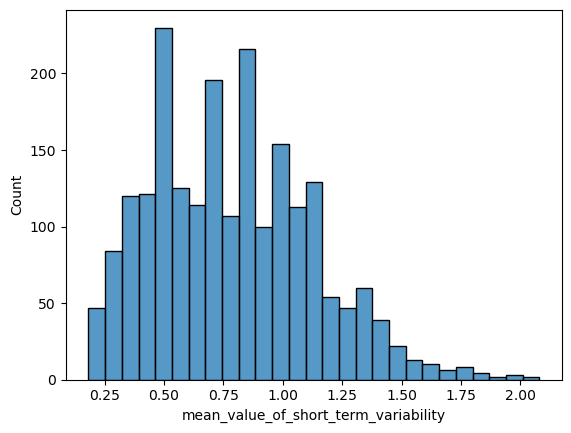

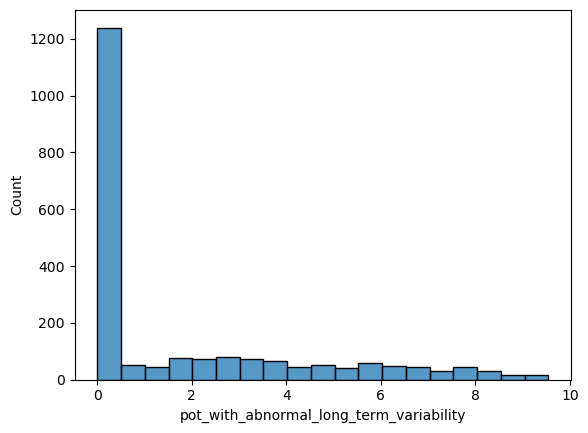

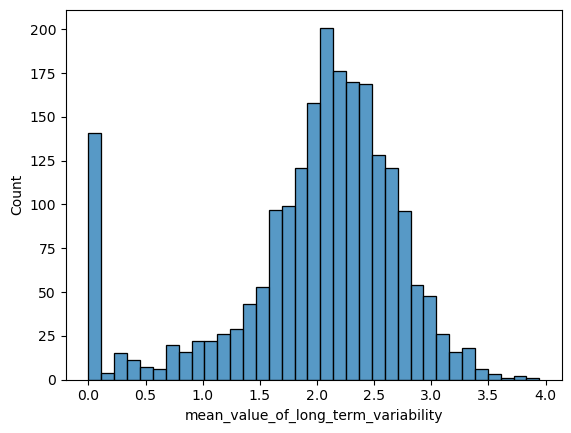

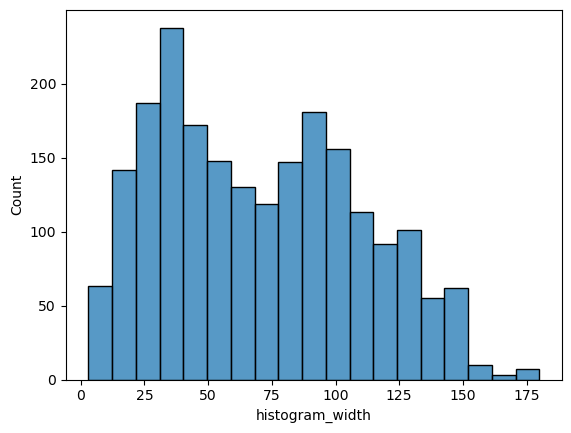

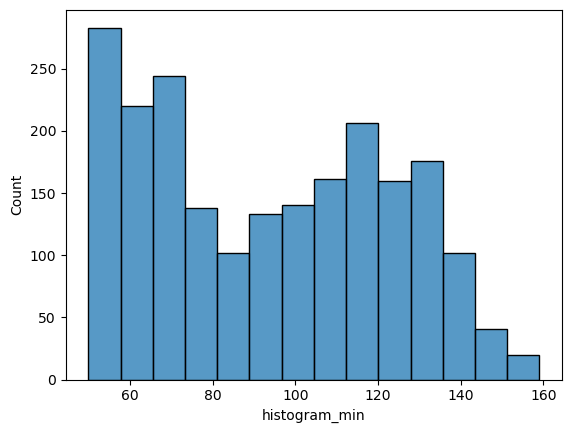

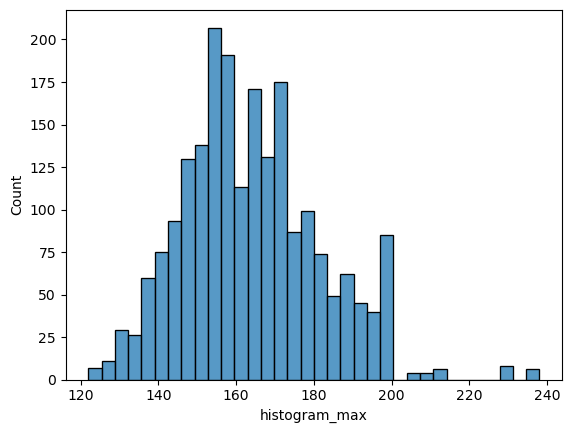

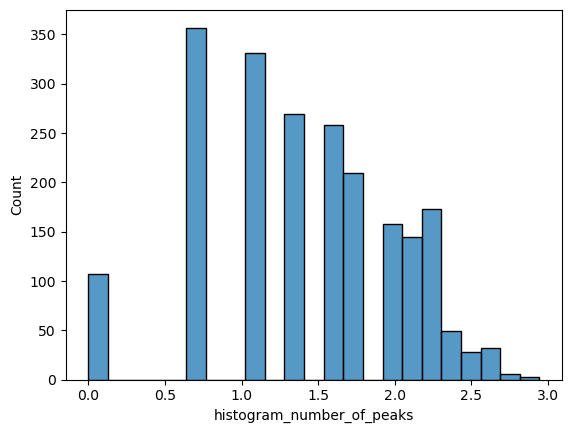

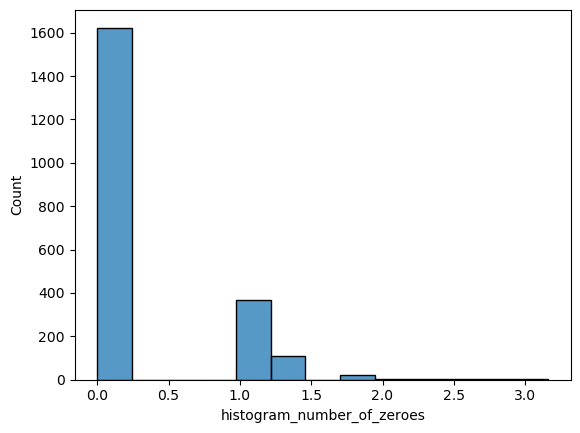

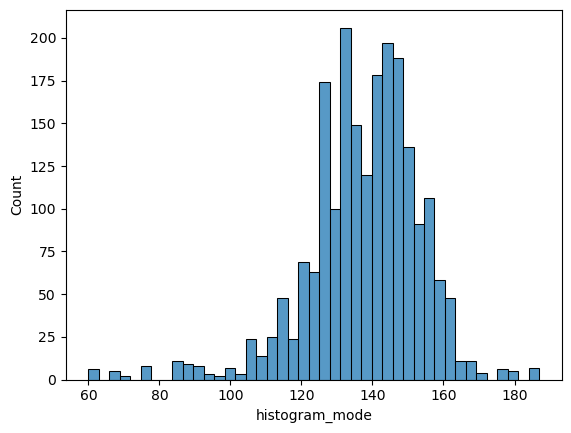

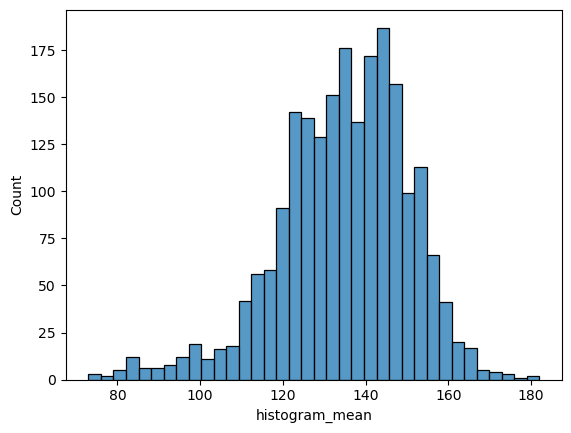

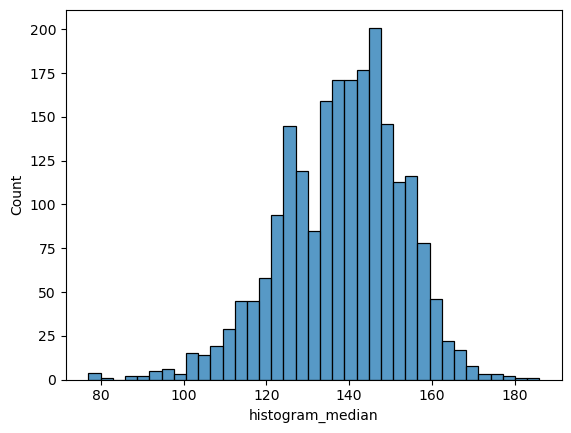

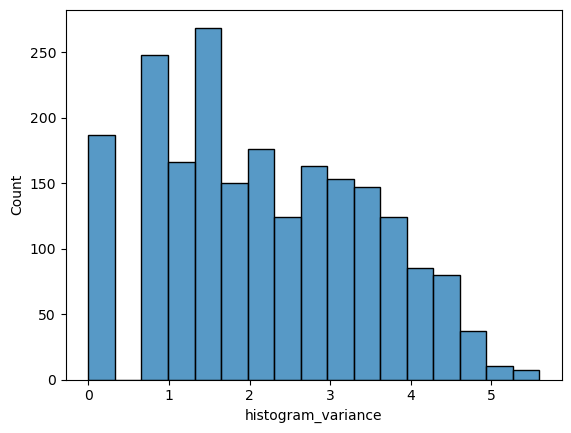

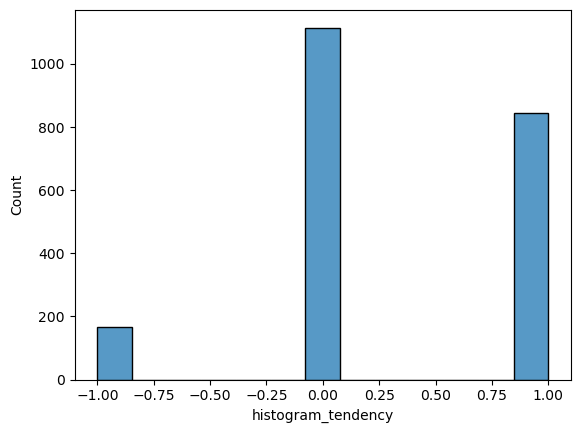

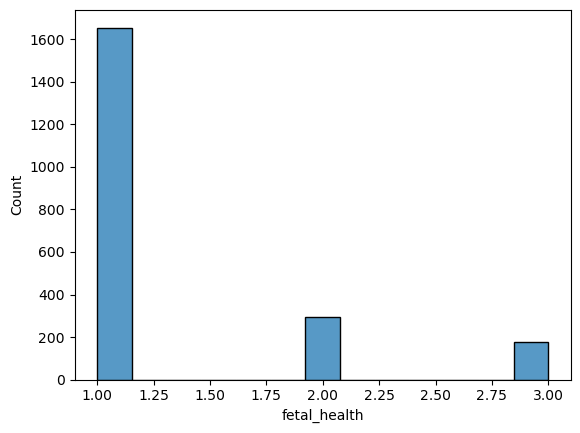

In [13]:
for c in df.columns:
    
    sns.histplot(df[c])
    plt.show()

Let's now split our dataset in train, validation, and test, and perform feature scaling and mean normalization on the full_train, train, validation, and test sets, using the parameters learned on the full_train set. 

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [15]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

Let's first remove our target variable from our full_train, train, validation, and test sets:

In [16]:
y_full_train = df_full_train['fetal_health'].values
y_train      = df_train['fetal_health'].values
y_val        = df_val['fetal_health'].values
y_test       = df_test['fetal_health'].values

del df_full_train['fetal_health']
del df_train['fetal_health']
del df_val['fetal_health']
del df_test['fetal_health']

Let's now perform feature scaling and mean normalization altogether:

In [17]:
scaler               = MinMaxScaler()

# fitting the scaler to the full_train set, so that it learns the parameters
scaler.fit(df_full_train)

# now let's apply the transformations to the full_train set. 
df_full_train_arr    = scaler.transform(df_full_train)
df_full_train_scaled = pd.DataFrame(df_full_train_arr, columns=df_full_train.columns)

# we need to apply the same transformation also to the train, validation, and test sets.
df_train_arr         = scaler.transform(df_train)
df_train_scaled      = pd.DataFrame(df_train_arr, columns=df_train.columns)

df_val_arr           = scaler.transform(df_val)
df_val_scaled        = pd.DataFrame(df_val_arr, columns=df_val.columns)

df_test_arr          = scaler.transform(df_test)
df_test_scaled       = pd.DataFrame(df_test_arr, columns=df_test.columns)

Let's get some descriptive statistics on the scaled dataframes:

In [18]:
df_full_train_scaled.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,pot_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,...,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,0.506242,0.292085,0.058918,0.292039,0.222466,0.003529,0.053102,0.465373,0.322525,0.186233,...,0.385224,0.393335,0.357028,0.493051,0.086601,0.608828,0.563432,0.555479,0.393825,0.662353
std,0.179137,0.283329,0.128349,0.196635,0.284791,0.059321,0.175963,0.228729,0.181079,0.267443,...,0.220026,0.271240,0.154987,0.210737,0.159919,0.129525,0.143814,0.133817,0.237408,0.307538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.388889,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.266667,0.184823,0.000000,...,0.192090,0.146789,0.252174,0.373114,0.000000,0.543307,0.477064,0.472222,0.198260,0.500000
50%,0.500000,0.324443,0.000000,0.333333,0.000000,0.000000,0.000000,0.480000,0.321636,0.000000,...,0.370056,0.376147,0.339130,0.546603,0.000000,0.622047,0.577982,0.564815,0.385893,0.500000
75%,0.629630,0.561951,0.078975,0.466667,0.447214,0.000000,0.000000,0.653333,0.430306,0.347677,...,0.553672,0.642202,0.443478,0.660876,0.000000,0.692913,0.660550,0.648148,0.587970,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df_train_scaled.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,pot_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,...,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,0.505969,0.293876,0.062330,0.293908,0.225267,0.004706,0.051822,0.467430,0.325104,0.184519,...,0.385293,0.392020,0.355887,0.491852,0.083409,0.608393,0.563260,0.555672,0.392755,0.663529
std,0.177313,0.284689,0.133396,0.197261,0.285668,0.068465,0.173105,0.228046,0.181494,0.267385,...,0.220535,0.271986,0.153288,0.214733,0.158807,0.131388,0.143598,0.133667,0.238510,0.309649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.388889,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.266667,0.184823,0.000000,...,0.192090,0.146789,0.252174,0.373114,0.000000,0.543307,0.477064,0.472222,0.198260,0.500000
50%,0.500000,0.324443,0.000000,0.333333,0.000000,0.000000,0.000000,0.493333,0.321636,0.000000,...,0.372881,0.376147,0.339130,0.546603,0.000000,0.622047,0.568807,0.564815,0.396520,0.500000
75%,0.629630,0.561951,0.078975,0.466667,0.447214,0.000000,0.000000,0.653333,0.449604,0.347677,...,0.553672,0.642202,0.443478,0.660876,0.000000,0.692913,0.660550,0.648148,0.580892,1.000000
max,1.000000,0.945905,0.995833,1.000000,1.000000,1.000000,1.000000,1.000000,0.935819,1.000000,...,0.977401,1.000000,1.000000,1.000000,1.000000,1.000000,0.981651,0.972222,1.000000,1.000000


In [20]:
df_val_scaled.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,pot_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.0,425.000000,425.000000,425.000000,425.000000,...,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.507059,0.286713,0.048684,0.286431,0.214060,0.0,0.056945,0.459200,0.314788,0.191378,...,0.385018,0.397280,0.360450,0.496646,0.096177,0.610134,0.563950,0.554902,0.397034,0.658824
std,0.184713,0.279470,0.111368,0.194867,0.282310,0.0,0.184428,0.230926,0.179819,0.267867,...,0.218751,0.269271,0.160111,0.198466,0.163025,0.123909,0.144630,0.134422,0.234320,0.301449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013333,0.000000,0.000000,...,0.000000,0.000000,0.026087,0.000000,0.000000,0.086614,0.091743,0.129630,0.000000,0.000000
25%,0.370370,0.000000,0.000000,0.133333,0.000000,0.0,0.000000,0.266667,0.184823,0.000000,...,0.197740,0.155963,0.252174,0.373114,0.000000,0.535433,0.477064,0.472222,0.198260,0.500000
50%,0.500000,0.324443,0.000000,0.266667,0.000000,0.0,0.000000,0.440000,0.296951,0.000000,...,0.355932,0.394495,0.339130,0.546603,0.000000,0.622047,0.577982,0.574074,0.375265,0.500000
75%,0.648148,0.512989,0.064483,0.400000,0.516398,0.0,0.000000,0.653333,0.430306,0.347677,...,0.536723,0.633028,0.443478,0.660876,0.316228,0.692913,0.669725,0.648148,0.587970,1.000000
max,0.981481,1.000000,1.000000,0.933333,0.966092,0.0,0.894427,0.986667,1.000000,0.994490,...,1.000000,0.990826,1.000000,0.962225,0.547723,0.992126,1.000000,1.000000,0.970046,1.000000


In [21]:
df_test_scaled.describe()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,pot_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,0.503173,0.300042,0.054168,0.287324,0.195175,0.002347,0.038047,0.471174,0.311724,0.195176,...,0.364394,0.425658,0.355603,0.477142,0.079177,0.613970,0.572425,0.560033,0.376559,0.651408
std,0.194320,0.290476,0.126161,0.195668,0.264081,0.048450,0.148588,0.231468,0.179523,0.280053,...,0.219809,0.269784,0.160336,0.222801,0.152850,0.126881,0.139948,0.134575,0.236941,0.296982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022599,0.000000,-0.008696,0.000000,0.000000,0.000000,0.082569,-0.009259,0.000000,0.000000
25%,0.351852,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.266667,0.184823,0.000000,...,0.180791,0.174312,0.236957,0.235409,0.000000,0.543307,0.477064,0.462963,0.198260,0.500000
50%,0.500000,0.324443,0.000000,0.266667,0.000000,0.000000,0.000000,0.506667,0.321636,0.000000,...,0.319209,0.458716,0.339130,0.470818,0.000000,0.629921,0.582569,0.574074,0.375265,0.500000
75%,0.648148,0.561951,0.064483,0.400000,0.365148,0.000000,0.000000,0.663333,0.430306,0.347677,...,0.536723,0.642202,0.467391,0.660876,0.000000,0.692913,0.669725,0.648148,0.555724,1.000000
max,0.981481,0.973329,0.988499,0.800000,1.000000,1.000000,0.894427,0.960000,1.006675,1.000000,...,0.977401,0.963303,1.000000,0.919717,0.836660,0.992126,0.935780,0.925926,1.010315,1.000000


Let's now visualize the scaled and transformed distributions for the `df_full_train_scaled` dataset:

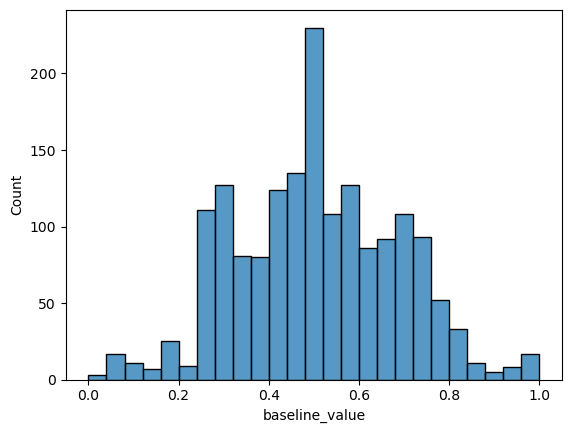

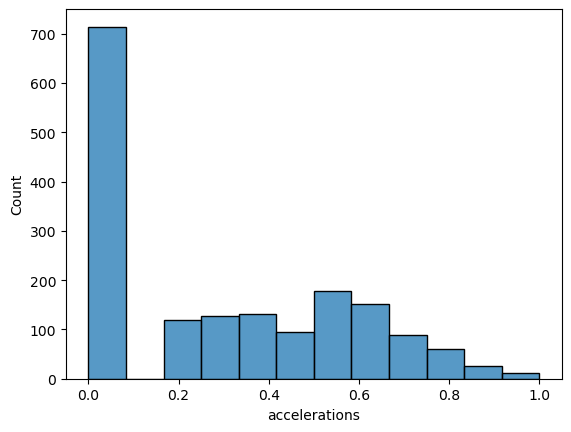

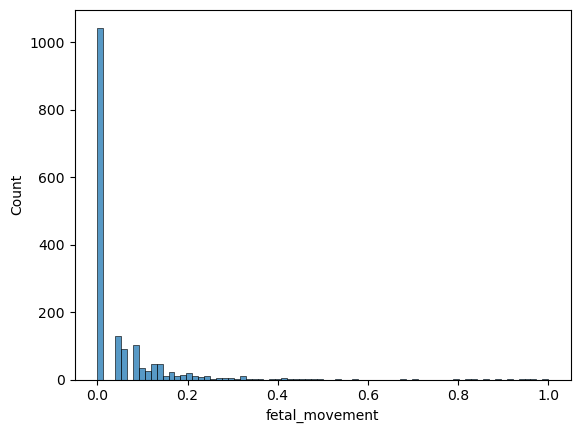

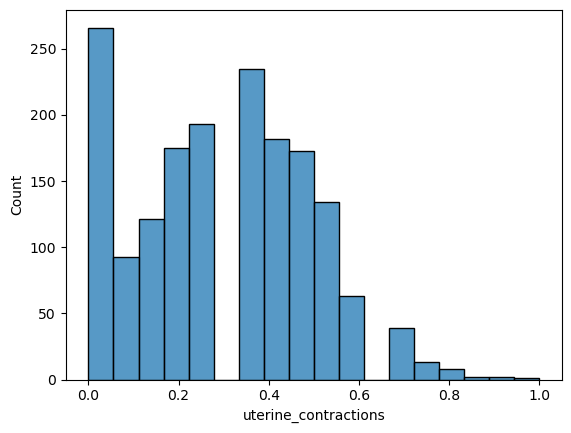

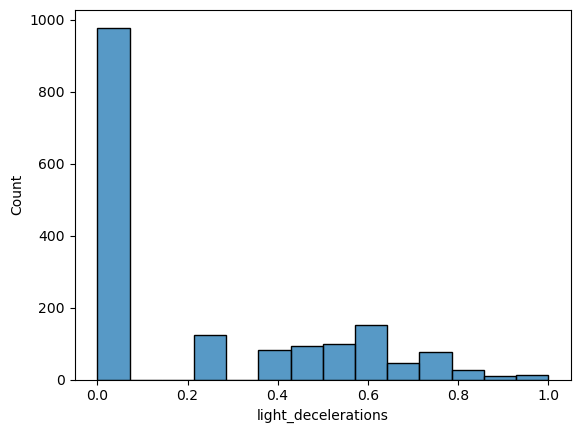

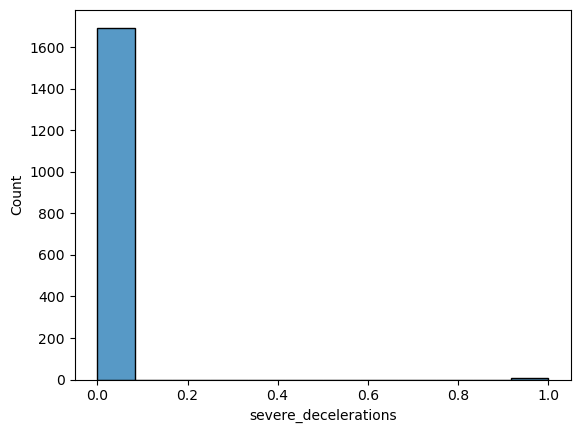

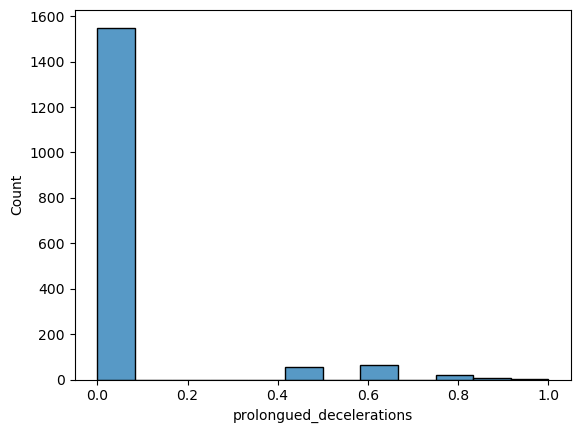

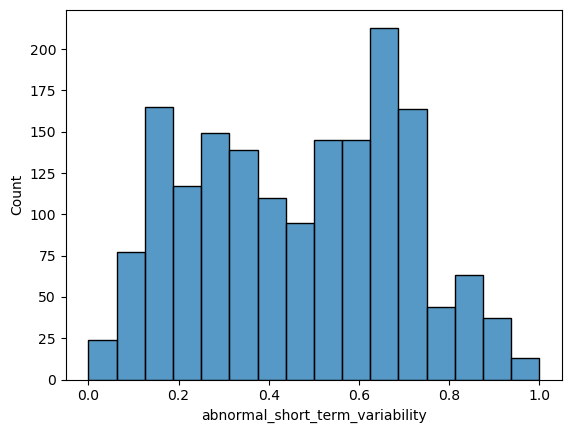

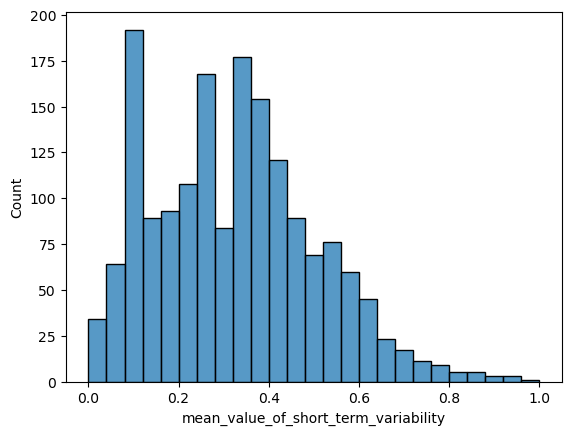

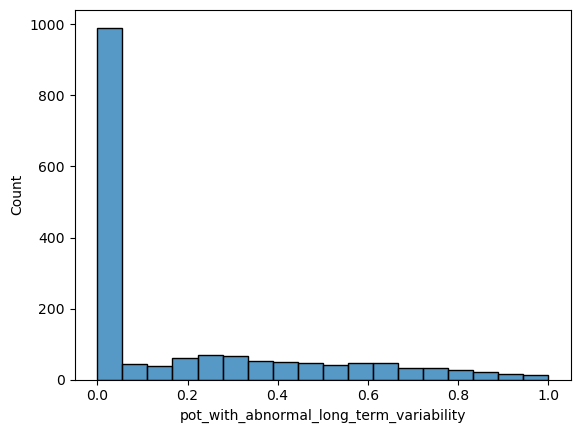

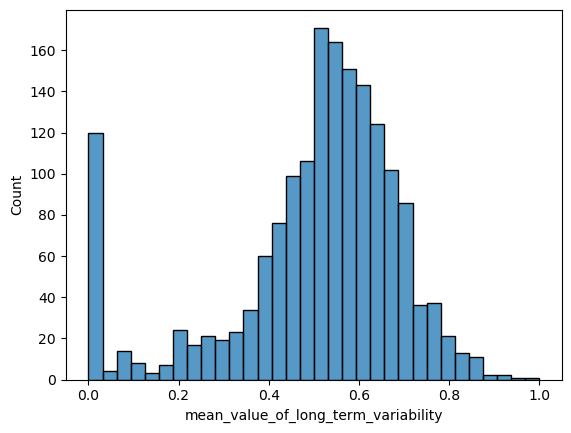

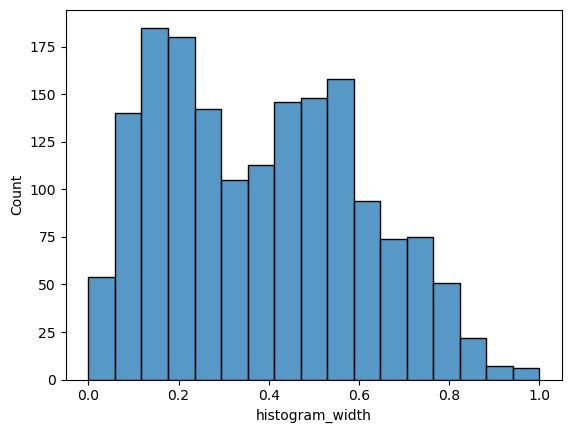

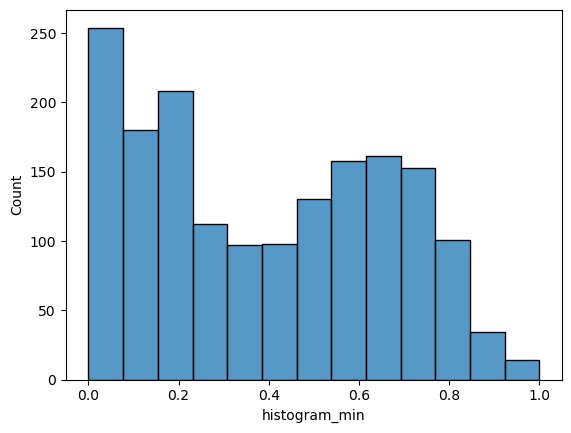

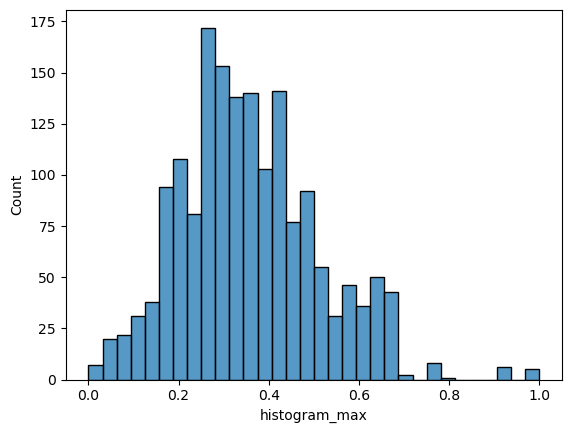

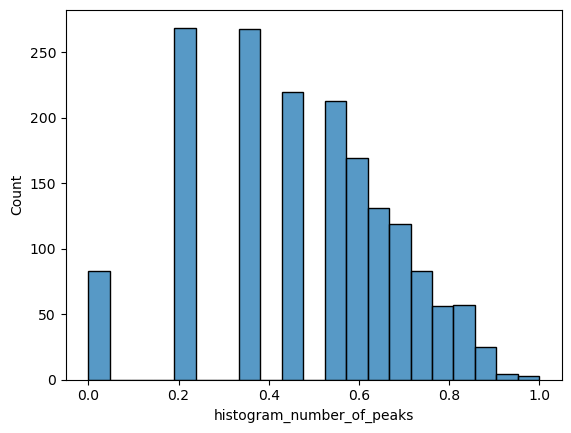

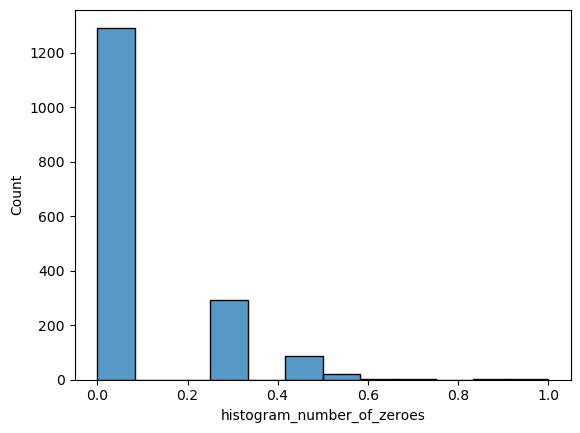

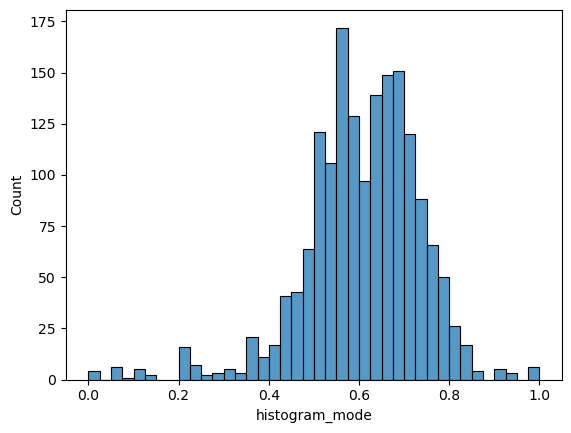

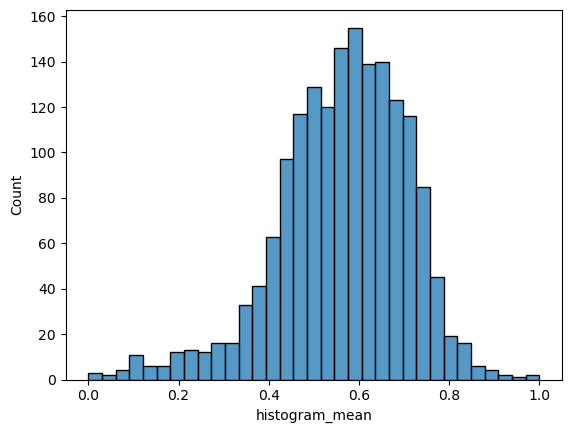

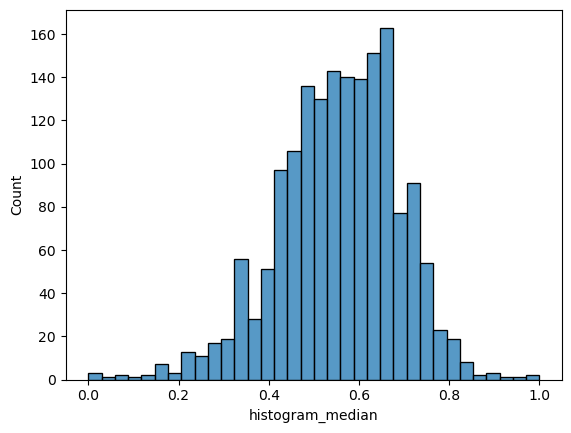

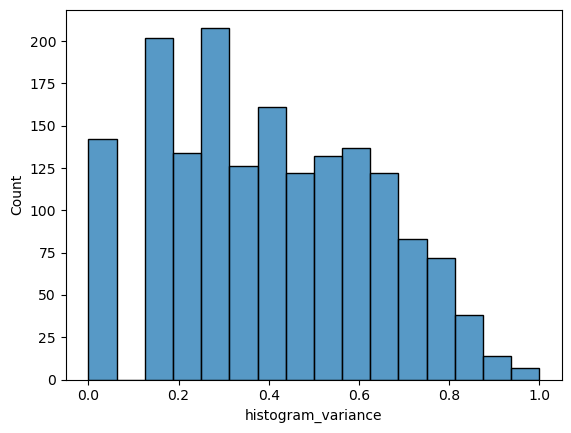

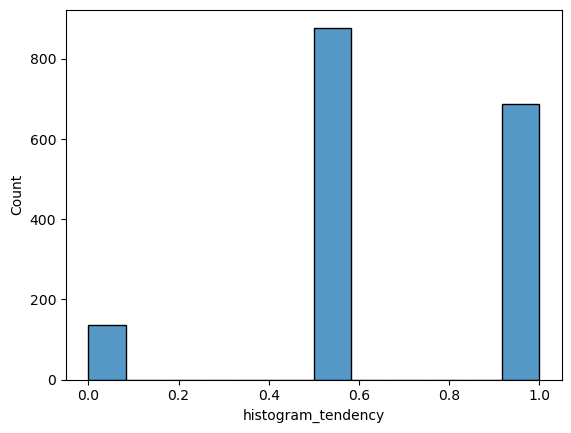

In [22]:
for c in df_full_train_scaled.columns:
    
    sns.histplot(df_full_train_scaled[c])
    plt.show()

Finally, let's reset the indexes and rename our dataframes:

In [23]:
df_full_train = df_full_train_scaled.reset_index(drop=True)
df_train      = df_train_scaled.reset_index(drop=True)
df_val        = df_val_scaled.reset_index(drop=True)
df_test       = df_test_scaled.reset_index(drop=True)

## EDA

For the purpose of EDA let's re-add the target variable in our dataframe:

In [24]:
df_full_train_eda                 = df_full_train.copy()
df_full_train_eda['fetal_health'] = y_full_train

Let's assess the proportion of examples in each class in the full_train set:

In [25]:
df_full_train_eda.fetal_health.value_counts(normalize=True)

1.0    0.781765
2.0    0.133529
3.0    0.084706
Name: fetal_health, dtype: float64

So, we have quite some class imbalance.

Let's assess the correlation between our features and our target variable. Keep in mind: all our features are numerical.

In [26]:
abs_corr = df_full_train.corrwith(df_full_train_eda.fetal_health).abs()
abs_corr.sort_values(ascending=False)

prolongued_decelerations                   0.483324
abnormal_short_term_variability            0.476323
accelerations                              0.416943
pot_with_abnormal_long_term_variability    0.347517
mean_value_of_long_term_variability        0.285791
histogram_mode                             0.276195
histogram_mean                             0.260070
histogram_median                           0.236713
uterine_contractions                       0.192408
mean_value_of_short_term_variability       0.157453
histogram_tendency                         0.155417
severe_decelerations                       0.131560
baseline_value                             0.122206
fetal_movement                             0.082177
histogram_number_of_peaks                  0.057325
histogram_width                            0.056896
histogram_min                              0.052235
histogram_variance                         0.048995
light_decelerations                        0.041462
histogram_ma

So, it seems that the three most important features are `prolongued_decelerations`, `abnormal_short_term_variability`, and `accelerations`.

Let's now see if the variables in the `df_full_train` set are correlated with each other or not.

In [27]:
df_full_train.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,pot_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
baseline_value,1.0,-0.099,-0.041,-0.14,-0.16,-0.065,-0.13,0.29,-0.32,0.32,0.016,-0.14,0.35,0.28,-0.12,-0.049,0.7,0.71,0.78,-0.22,0.29
accelerations,-0.099,1.0,0.1,0.11,-0.055,-0.05,-0.13,-0.32,0.27,-0.48,-0.12,0.32,-0.17,0.42,0.24,2.4e-06,0.23,0.26,0.26,0.35,0.018
fetal_movement,-0.041,0.1,1.0,-0.2,0.056,-0.013,0.22,-0.018,0.15,-0.1,-0.023,0.23,-0.2,0.17,0.19,-0.058,-0.02,-0.066,-0.033,0.19,0.0028
uterine_contractions,-0.14,0.11,-0.2,1.0,0.3,0.0024,0.12,-0.23,0.33,-0.31,-0.12,0.14,-0.1,0.13,0.13,0.083,-0.11,-0.19,-0.14,0.3,-0.078
light_decelerations,-0.16,-0.055,0.056,0.3,1.0,0.098,0.31,-0.17,0.61,-0.36,-0.33,0.57,-0.6,0.25,0.46,0.29,-0.33,-0.52,-0.38,0.71,0.043
severe_decelerations,-0.065,-0.05,-0.013,0.0024,0.098,1.0,0.0073,0.05,0.05,-0.041,-0.094,0.048,-0.074,-0.019,0.03,0.054,-0.24,-0.18,-0.18,0.1,-0.096
prolongued_decelerations,-0.13,-0.13,0.22,0.12,0.31,0.0073,1.0,0.044,0.3,-0.19,-0.36,0.29,-0.3,0.12,0.23,0.069,-0.44,-0.52,-0.46,0.41,-0.21
abnormal_short_term_variability,0.29,-0.32,-0.018,-0.23,-0.17,0.05,0.044,1.0,-0.5,0.47,-0.28,-0.26,0.28,-0.11,-0.18,-0.17,0.044,0.059,0.1,-0.34,-0.023
mean_value_of_short_term_variability,-0.32,0.27,0.15,0.33,0.61,0.05,0.3,-0.5,1.0,-0.64,-0.17,0.71,-0.68,0.42,0.53,0.31,-0.32,-0.47,-0.35,0.75,-0.049
pot_with_abnormal_long_term_variability,0.32,-0.48,-0.1,-0.31,-0.36,-0.041,-0.19,0.47,-0.64,1.0,0.035,-0.49,0.46,-0.31,-0.34,-0.17,0.2,0.27,0.23,-0.62,0.047


`histogram_mean`, `histogram_mode`, and `histogram_median` appear to be quite correlated with each others.

## Logistic regression

Let's first train a multiclass logistic regression model as "baseline" model, and evaluate its accuracy.

In [28]:
dv         = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient = 'records')
X_train    = dv.fit_transform(train_dict)

LR1        = LogisticRegression(multi_class='ovr', max_iter=10000, random_state=1)
LR1.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', random_state=1)

Let's evaluate this LR1 model on the training set.

In [29]:
y_train_pred = LR1.predict(X_train)
round((y_train_pred == y_train).mean(), 3)

0.893

Let's now evaluate this LR1 model on the validation set.

In [30]:
val_dict = df_val.to_dict(orient = 'records')
X_val    = dv.transform(val_dict) 

In [31]:
y_val_pred = LR1.predict(X_val)
round((y_val_pred == y_val).mean(), 3)

0.892

So, with this "baseline" model we have 89.2% accuracy on the validation set. However, let's keep in mind that we have class imbalance. Let's look at the F1 score. We take a macro-average to avoid to give less weight to smaller classes.

In [32]:
LR1_F1_train = f1_score(y_train_pred, y_train, average = 'macro')
round(LR1_F1_train, 3)

0.765

In [33]:
LR_F1_val = f1_score(y_val_pred, y_val, average = 'macro')
round(LR_F1_val, 3)

0.791

So, our macro-averaged F1 score for model LR1 is 0.765 on the training set, and 0.791 on the validation set. 

Anyways, let's get some more info with the classification report and by having a look at the confusion matrix for our predictions for the validation set.

In [34]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         1.0       0.92      0.97      0.94       329
         2.0       0.65      0.62      0.64        58
         3.0       1.00      0.66      0.79        38

    accuracy                           0.89       425
   macro avg       0.86      0.75      0.79       425
weighted avg       0.89      0.89      0.89       425



In [35]:
cnf_matrix = confusion_matrix(y_val, y_val_pred)
cnf_matrix

array([[318,  11,   0],
       [ 22,  36,   0],
       [  5,   8,  25]])

So, class 2 is the one with worse F1 score. Anyways, let's consider our macro-average value of 0.79, and let's move on considering another model.

## Decision Trees

Let's now use Decision Trees (DT) to classify fethal health in our three classes.

Let's do this for ranges of different depth values and different minimum samples per leaf values.

In [36]:
depths      = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
min_samples = [1, 5, 10, 20, 50, 100, 200]

# create empty list on which to store F1 values
DT_F1       = []

for d in depths:
    
    for s in min_samples:

        # fit the model
        DT         = DecisionTreeClassifier(max_depth = d, min_samples_leaf=s, random_state=1)
        DT.fit(X_train, y_train)
    
        # compute predictions on the validation set
        y_val_pred = DT.predict(X_val)
    
        # compute macro-averaged F1 score
        DT_F1_val  = f1_score(y_val_pred, y_val, average = 'macro')
    
        # store DT_F1_val in DT_F1 as a tuple
        DT_F1.append((d, s, DT_F1_val))

Let's convert our `DT_F1` in a dataframe:

In [37]:
columns  = ['max_depth', 'min_samples_leaf', 'F1_score']
DT_F1_df = pd.DataFrame(DT_F1, columns=columns)
DT_F1_df

,max_depth,min_samples_leaf,F1_score
0,1,1,0.497950
1,1,5,0.497950
2,1,10,0.497950
3,1,20,0.497950
4,1,50,0.497950
...,...,...,...
65,20,10,0.853623
66,20,20,0.862540
67,20,50,0.750697
68,20,100,0.694210


Let's now visualize the values by sorting them in descending order.

In [38]:
DT_F1_df.sort_values(by = 'F1_score', ascending=False)

,max_depth,min_samples_leaf,F1_score
35,6,1,0.885754
28,5,1,0.885018
29,5,5,0.877583
64,20,5,0.876281
57,15,5,0.876281
...,...,...,...
5,1,100,0.497950
4,1,50,0.497950
3,1,20,0.497950
2,1,10,0.497950


It seems that the largest values are achieved by `min_samples_leaf=1` with `max_depth=6` or `max_depth=5`.

Let's anyways plot this as a heatmap. For this, let's transform `DT_F1_df` in a table using `pivot`:

In [39]:
DT_F1_table = DT_F1_df.pivot(index = 'min_samples_leaf', columns = 'max_depth', values = 'F1_score')
DT_F1_table.round(3)

max_depth,1,2,3,4,5,6,8,10,15,20
min_samples_leaf,,,,,,,,,,
1,0.498,0.759,0.836,0.843,0.885,0.886,0.850,0.858,0.871,0.871
5,0.498,0.759,0.836,0.846,0.878,0.875,0.875,0.876,0.876,0.876
10,0.498,0.759,0.827,0.837,0.858,0.850,0.850,0.854,0.854,0.854
20,0.498,0.759,0.829,0.840,0.863,0.863,0.863,0.863,0.863,0.863
50,0.498,0.751,0.751,0.751,0.751,0.751,0.751,0.751,0.751,0.751
100,0.498,0.694,0.694,0.694,0.694,0.694,0.694,0.694,0.694,0.694
200,0.498,0.498,0.498,0.498,0.498,0.498,0.498,0.498,0.498,0.498


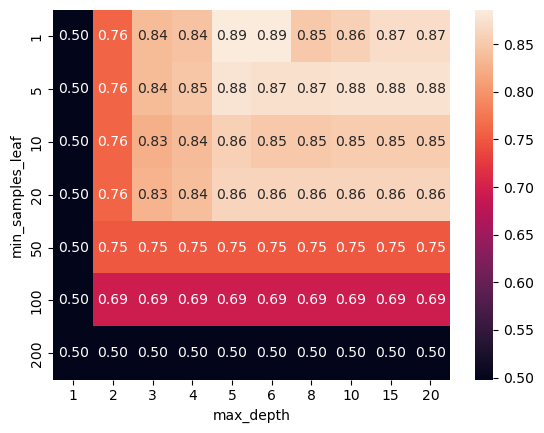

In [40]:
sns.heatmap(DT_F1_table, annot=True, fmt='.2f')

So, we got a maximum F1 score on the validation set of 0.886, which is quite an improvement compared to the F1 score for our logistic regression which for the validation set was 0.79. Let's now train the "final" DT with `max_depth=6` and `min_samples_leaf=1` to visualize its classification report, its confusion matrix, and the tree itself. 

In [41]:
DT         = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1, random_state=1)
DT.fit(X_train, y_train)

# compute predictions on the validation set
y_val_pred = DT.predict(X_val)
    
# compute macro-averaged F1 score
DT_F1_val  = f1_score(y_val_pred, y_val, average = 'macro')

In [42]:
DT_F1_val.round(3)

0.886

In [43]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

         1.0       0.97      0.94      0.96       338
         2.0       0.69      0.80      0.74        50
         3.0       0.95      0.97      0.96        37

    accuracy                           0.93       425
   macro avg       0.87      0.91      0.89       425
weighted avg       0.93      0.93      0.93       425



In [44]:
cnf_matrix_DT = confusion_matrix(y_val, y_val_pred)
cnf_matrix_DT

array([[319,   9,   1],
       [ 18,  40,   0],
       [  1,   1,  36]])

In [45]:
#fig = plt.figure(figsize=(20,7))
#p1  = plot_tree(DT, 
#                feature_names=dv.get_feature_names(),  
#                class_names=['1', '2', '3'],
#                filled=True,
#                fontsize=6)


/home/lisa/anaconda3/envs/ml-zoomcamp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/home/lisa/anaconda3/envs/ml-zoomcamp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/lisa/anaconda3/envs/ml-zoomcamp/lib/python3.7/site-packages/matplotlib/cbook/__

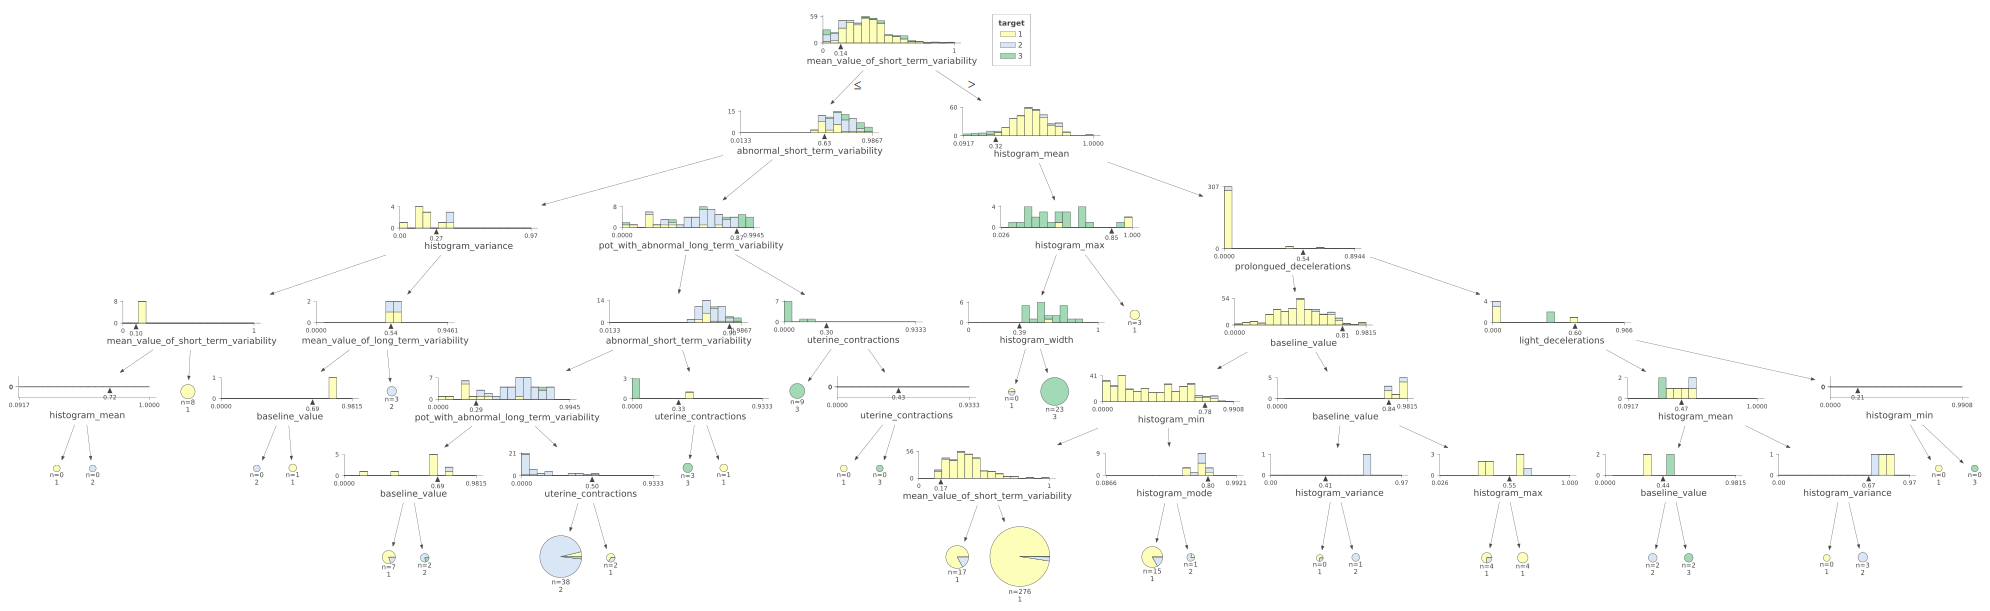

In [46]:
viz = dtreeviz(DT, X_val, y_val,
                target_name="target",
                feature_names=dv.get_feature_names(),
                class_names=['1', '2', '3'])

viz

## Random Forest

Let's now train different Random Forest models, by changing the number of estimators `n_estimators`. the maximum depth `max_depth`, and the minimum samples per leaf `min_samples_leaf`.

In [47]:
estimators = range(10, 201, 10)

In [48]:
RF_F1 = []

for i in estimators:
    
    for d in depths:
        
        for s in min_samples:
            
            # let's train the model
            RF = RandomForestClassifier(n_estimators=i,
                                        max_depth=d,
                                        min_samples_leaf=s,
                                        random_state=1)
            
            RF.fit(X_train, y_train)
            
            # let's now compute predictions
            y_val_pred = RF.predict(X_val)
            RF_F1_val  = f1_score(y_val_pred, y_val, average='macro')
            
            RF_F1.append((i, d, s, RF_F1_val))
            
RF_F1_df = pd.DataFrame(RF_F1, columns = ['n_estimators', 'max_depth', 'min_samples_leaf', 'f1_score'])

In [49]:
RF_F1_df.sort_values(by = 'f1_score', ascending = False)

,n_estimators,max_depth,min_samples_leaf,f1_score
756,110,15,1,0.910931
826,120,15,1,0.910931
833,120,20,1,0.910931
392,60,8,1,0.910209
973,140,20,1,0.907095
...,...,...,...,...
734,110,5,200,0.290893
727,110,4,200,0.290893
720,110,3,200,0.290893
713,110,2,200,0.290893


So it seems that the largest `f1_score` values correspond to:

-`n_estimators = 110`, `max_depth = 15`, `min_samples_leaf = 1`

-`n_estimators = 120`, `max_depth = 15`, `min_samples_leaf = 1`

-`n_estimators = 120`, `max_depth = 20`, `min_samples_leaf = 1`

For the more simplicity of the model, we take the model corresponding to `n_estimators = 110`, `max_depth = 15`, `min_samples_leaf = 1`.

Let's re-train it and visualize its classification report, and the confusion matrix:

In [51]:
RF = RandomForestClassifier(n_estimators = 110,
                            max_depth = 15,
                            min_samples_leaf = 1,
                            random_state=1)

RF.fit(X_train, y_train)

y_val_pred = RF.predict(X_val)
RF_F1_val  = f1_score(y_val_pred, y_val, average = 'macro')

In [52]:
RF_F1_val

0.9109305603591312

Let's now visualize the classification report:

In [53]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97       341
         2.0       0.74      0.88      0.80        49
         3.0       0.92      1.00      0.96        35

    accuracy                           0.95       425
   macro avg       0.88      0.94      0.91       425
weighted avg       0.95      0.95      0.95       425



In [54]:
cnf_matrix_RF = confusion_matrix(y_val, y_val_pred)
cnf_matrix_RF

array([[325,   4,   0],
       [ 15,  43,   0],
       [  1,   2,  35]])

We can clearly see that still the class 2 is the one with smaller precision and recall. However, the macro-averaged F1 score of this Random Forest model is 0.91, which is larger than the one of the Decision Tree. 

## Gradient Boosted Tree

To build a Gradient Boosted Tree, we use XGBoost, and for that, we need to use a special data structure, the D-Matrix. For choosing the best Gradient Boosted Tree model we use as metric AUC, as it is already implemented. The, we will compute the F1 score for comparing it to the other models. 

In [55]:
features = list(dv.get_feature_names_out())
features

['abnormal_short_term_variability',
 'accelerations',
 'baseline_value',
 'fetal_movement',
 'histogram_max',
 'histogram_mean',
 'histogram_median',
 'histogram_min',
 'histogram_mode',
 'histogram_number_of_peaks',
 'histogram_number_of_zeroes',
 'histogram_tendency',
 'histogram_variance',
 'histogram_width',
 'light_decelerations',
 'mean_value_of_long_term_variability',
 'mean_value_of_short_term_variability',
 'pot_with_abnormal_long_term_variability',
 'prolongued_decelerations',
 'severe_decelerations',
 'uterine_contractions']

Let's create the D-Matrices for the training and the validation sets:

In [56]:
y_train_xgb = y_train - 1
y_val_xgb   = y_val - 1

dtrain      = xgb.DMatrix(X_train, label = y_train_xgb, feature_names=features)
dval        = xgb.DMatrix(X_val, label = y_val_xgb, feature_names=features)

Let's now train different gradient boosted trees, by changing the `eta` and then the `max_depth` parameter, and monitoring what happens for the different numbers of estimators. Let's monitor that by evaluating the model on the validation set. For this reason, we create the `watchlist` variable as follows:

In [57]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Let's then create a function for parsing xgb's output about the different number of estimators as in Alexey's tutorial:

In [58]:
def parse_xgb_output(output):
    
    results = []
    tree = []
    aucs_train = []
    aucs_val = []
    
    for line in output.stdout.strip().split('\n'):
        
        it_line, train_line, val_line = line.split('\t')
        
        it    = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val   = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns = columns)
    
    return df_results

Let's now try out our tree for `eta = 0.3`. The output will then be stored in the dictionary `scores`.

In [59]:
scores = {}

In [60]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

Let's create a key that looks like this: "eta=0.3" for each value of eta to store the auc values for the training and the validation set for the `eta` value adopted. We can achieve this as follows as shown in Alexey's tutorial:

In [61]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Let's now try out our tree for `eta = 0.5`.

In [62]:
%%capture output

xgb_params = {
    
    'eta': 0.5,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [63]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Let's now try out our tree for `eta = 0.1`.

In [64]:
%%capture output

xgb_params = {
    
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [65]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Let's now try out our tree for `eta` = 0.7.

In [66]:
%%capture output

xgb_params = {
    
    'eta': 0.7,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [67]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Let's now visualize all the keys we have:

In [68]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.5', 'eta=0.1', 'eta=0.7'])

And let's now plot our results as done in Alexey's tutorial:

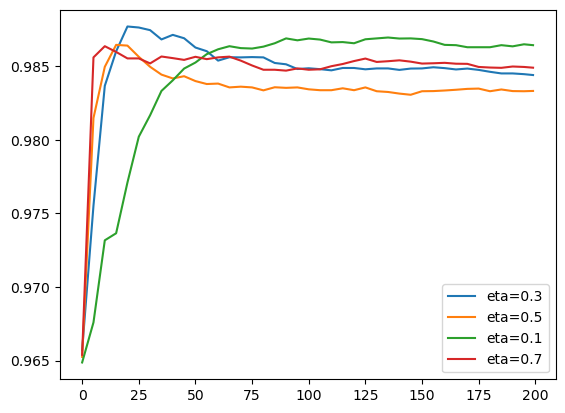

In [69]:
for key, df_score in scores.items():
    
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)

plt.legend()

It appears that the maximum value occurs for `eta = 0.3`. Let's see exactly at what number of estimators (then, there might be overfit):

In [70]:
scores['eta=0.3'].sort_values(by='val_auc', ascending = False).head()

,num_iter,train_auc,val_auc
4,20,1.0,0.98770
5,25,1.0,0.98763
6,30,1.0,0.98745
8,40,1.0,0.98713
9,45,1.0,0.98690


It occurs for 20 estimators! Let's fix `eta = 0.3` and look now at different `max_depth` values:

Let's create the `scores_max_depth` dictionary to store the XGB output:

In [71]:
scores_max_depth = {}

Let's now run the XGB model for `max_depth = 3`:

In [72]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [73]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

Let's now run the XGB model for `max_depth = 5`:

In [74]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [75]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

Let's now run the XGB model for `max_depth = 6`:

In [76]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [77]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

Let's now run the XGB model for `max_depth = 7`:

In [78]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [79]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

Let's now run the XGB model for `max_depth = 8`:

In [80]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [81]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

Let's now run the XGB model for `max_depth = 10`:

In [82]:
%%capture output

xgb_params = {
    
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    
}

XGB = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals = watchlist)

In [83]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores_max_depth[key] = parse_xgb_output(output)

In [84]:
scores_max_depth.keys()

dict_keys(['max_depth=3', 'max_depth=5', 'max_depth=6', 'max_depth=7', 'max_depth=8', 'max_depth=10'])

And let's now plot our results as shown by Andrey:

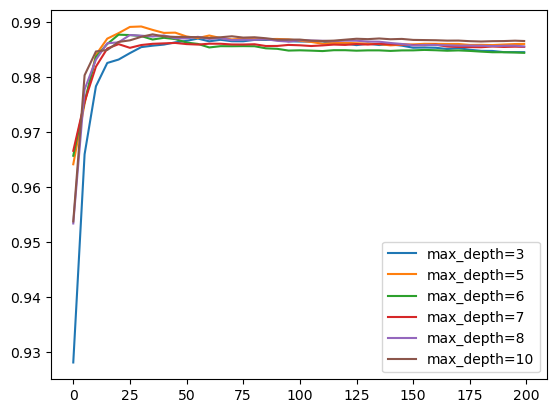

In [85]:
for key, df_score in scores_max_depth.items():
    
    plt.plot(df_score.num_iter, df_score.val_auc, label = key)

plt.legend()

We see that the largest auc value occur for `max_depth=5`, again at around 20 estimators. Let's see exactly at how many estimators:

In [86]:
scores_max_depth['max_depth=5'].sort_values(by = 'val_auc', ascending=False).head()

,num_iter,train_auc,val_auc
6,30,1.0,0.98919
5,25,1.0,0.98911
7,35,1.0,0.98857
9,45,1.0,0.98807
8,40,1.0,0.98802


The largest AUC occurs for 30 estimators.

Let's set then the number estimator to 30, the eta value at 0.3 and the maximum depth at 5, and train our final model to compute its F1 score.

In [87]:
xgb_params = {
    
    'eta': 0.3,
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

XGB = xgb.train(xgb_params, dtrain, num_boost_round=30)

Let's get our predictions on the validation set, and let's then compute the macro-averaged F1 score, and print the classification report and the confusion matrix:

In [88]:
y_val_pred = XGB.predict(dval)

XGB_F1_val = f1_score((y_val - 1), y_val_pred, average='macro')
XGB_F1_val

0.9091332604554406

In [89]:
print(classification_report((y_val - 1), y_val_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       329
         1.0       0.86      0.76      0.81        58
         2.0       0.93      0.97      0.95        38

    accuracy                           0.95       425
   macro avg       0.92      0.90      0.91       425
weighted avg       0.95      0.95      0.95       425



In [90]:
cnf_matrix = confusion_matrix(y_val_pred, (y_val - 1))
cnf_matrix

array([[322,  12,   0],
       [  6,  44,   1],
       [  1,   2,  37]])

Let's now decide which model to use based on the F1 scores! 

In [91]:
F1_df = pd.DataFrame([[LR_F1_val, DT_F1_val, RF_F1_val, XGB_F1_val]],
                      columns = ['LR_F1_val', 'DT_F1_val', 'RF_F1_val', 'XGB_F1_val'])
F1_df 

,LR_F1_val,DT_F1_val,RF_F1_val,XGB_F1_val
0,0.79148,0.885754,0.910931,0.909133


The largest F1 score corresponds to the Random Forest model! Let's re-train with the full_train dataset, compute the F1 score on the test set, and save it.

In [92]:
# let's create the feature matrix for df_full_train
full_train_dict = df_full_train.to_dict(orient = 'records')
X_full_train    = dv.transform(full_train_dict)

y_full_train.shape

(1700,)

In [94]:
# let's do the same for df_test
test_dict       = df_test.to_dict(orient = 'records')
X_test          = dv.transform(test_dict)

In [95]:
RF = RandomForestClassifier(n_estimators = 110,
                            max_depth = 15,
                            min_samples_leaf = 1,
                            random_state=1)

RF.fit(X_full_train, y_full_train)

y_test_pred = RF.predict(X_test)
RF_F1_test  = f1_score(y_test_pred, y_test, average = 'macro')
RF_F1_test

0.8722397030561103

In [96]:
print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.94      0.97       343
         2.0       0.68      0.90      0.77        51
         3.0       0.88      0.88      0.88        32

    accuracy                           0.93       426
   macro avg       0.85      0.91      0.87       426
weighted avg       0.95      0.93      0.94       426



In [97]:
cnf_matrix = confusion_matrix(y_test_pred, y_test)
cnf_matrix

array([[324,  18,   1],
       [  2,  46,   3],
       [  0,   4,  28]])

Let's now save the final model.

In [105]:
bentoml.sklearn.save_model("fethal_health_model", RF, custom_objects={"dictVectorizer": dv})

Model(tag="fethal_health_model:cvfhiic5cwm55h34", path="/home/lisa/bentoml/models/fethal_health_model/cvfhiic5cwm55h34/")